<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импортируем-необходимые-библиотеки" data-toc-modified-id="Импортируем-необходимые-библиотеки-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импортируем необходимые библиотеки</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Предобработка данных</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Результаты" data-toc-modified-id="Результаты-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Результаты</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import lightgbm as lgb
import numpy as np

### Предобработка данных

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.index.is_monotonic

True

In [6]:
print(df.describe())

         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000


In [7]:
print(pd.Series(df.index).describe())

count                   26496
unique                  26496
top       2018-03-09 22:10:00
freq                        1
first     2018-03-01 00:00:00
last      2018-08-31 23:50:00
Name: datetime, dtype: object


/tmp/ipykernel_557/2055718062.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(pd.Series(df.index).describe())


Заметим, что пропусков в данных нет , типы данных совпадают с описанием, индекс постоянно возрастает , даты распределены между мартом - августом 2018 года ,  промежуток составляет 10 минут. Ресемплируем промежуток до 1 часа 

In [8]:
df = df.resample('1H').sum()

In [9]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

In [10]:
sns.set(rc={'figure.figsize':(15,4)})

def lineplot(data, title):
    data.plot()
    plt.title(title)
    plt.show()

Разделим данные на трендовую, сезонную и шумовую состовляющие и построим соответствующие графики

In [11]:
decomposed = seasonal_decompose(df)

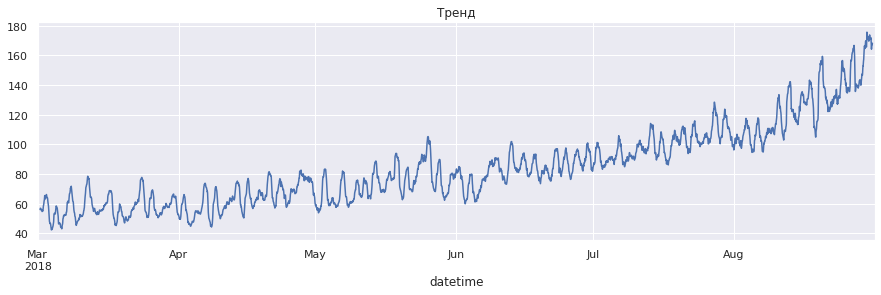

In [12]:
lineplot(decomposed.trend, 'Тренд')

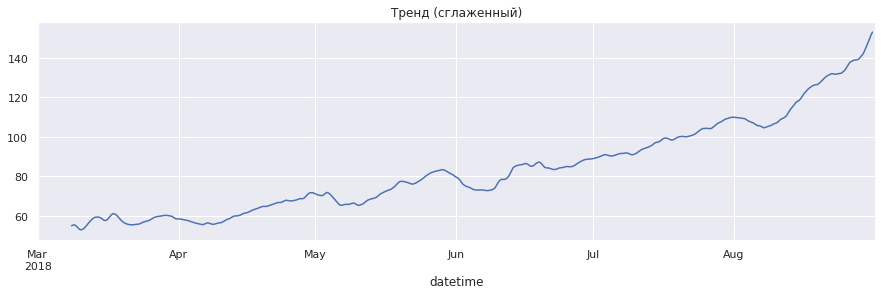

In [13]:
lineplot(decomposed.trend.rolling(24*7).mean(), 'Тренд (сглаженный)')

Наблюдаем тренд равномерного роста заказов с периодическими небольшими падениями. Количество заказов возрастает от весны к лету

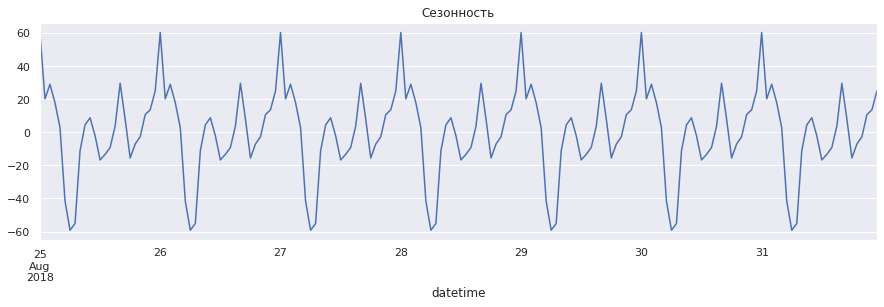

In [14]:
lineplot(decomposed.seasonal.tail(24*7), 'Сезонность')


Заметим, что присутствует сезонность по дням - спад ночью, рост с утра и днем, пик к вечеру

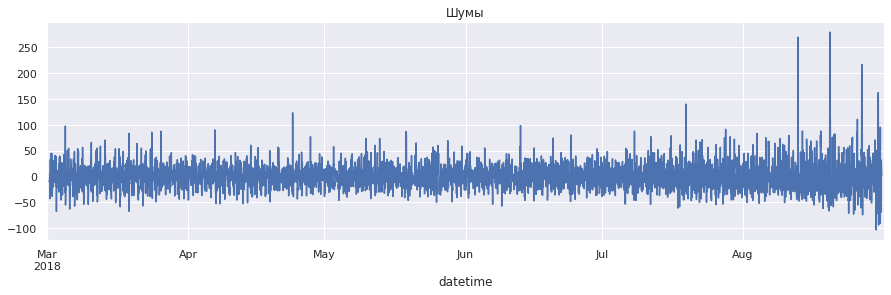

In [15]:
lineplot(decomposed.resid, 'Шумы')

In [16]:
df_daily = df.copy()
df_daily = df_daily.resample('1D').sum()

In [17]:
decomposed_daily = seasonal_decompose(df_daily)

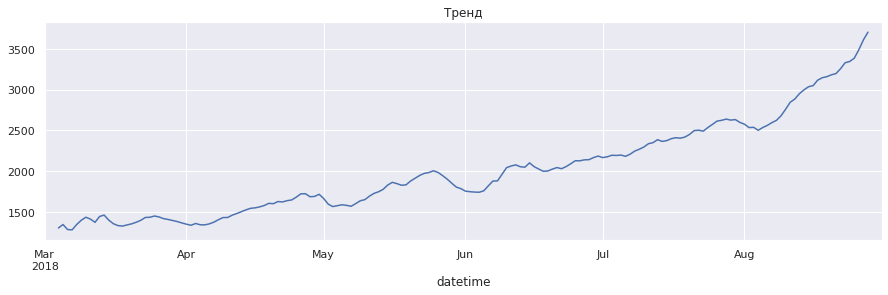

In [18]:
lineplot(decomposed_daily.trend, 'Тренд')

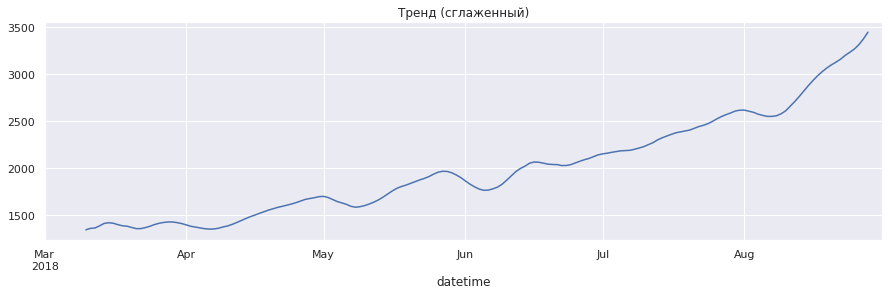

In [19]:
lineplot(decomposed_daily.trend.rolling(7).mean(), 'Тренд (сглаженный)')

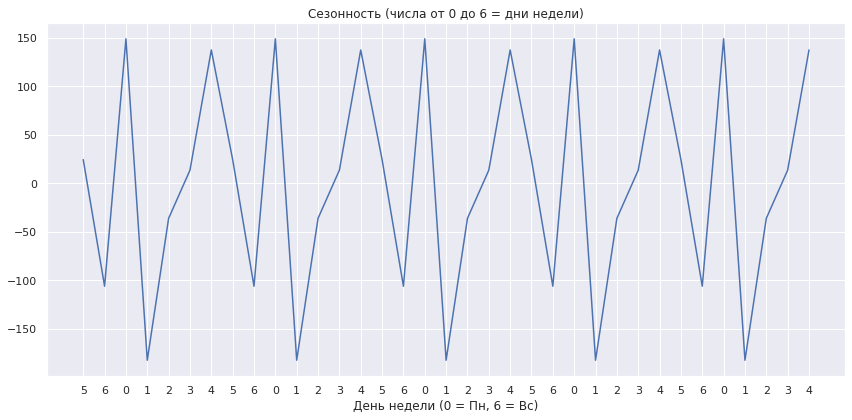

In [20]:
seasonality = decomposed_daily.seasonal.tail(7 * 5)
day_nums = seasonality.index.dayofweek 
plt.figure(figsize=(12, 6))
plt.plot(seasonality.values)
plt.title('Сезонность (числа от 0 до 6 = дни недели)')
plt.xticks(ticks=range(len(day_nums)), labels=day_nums)
plt.xlabel('День недели (0 = Пн, 6 = Вс)')
plt.grid(True)
plt.tight_layout()
plt.show()

Заметим, что наблюдается следующая недельная сезонность : пик заказов достигается в понедельник, а падает во вторник, далее  со среды по пятницу количество заказов увеличивается, достигая пика в пятницу, в выходные спрос заметно уменьшается 

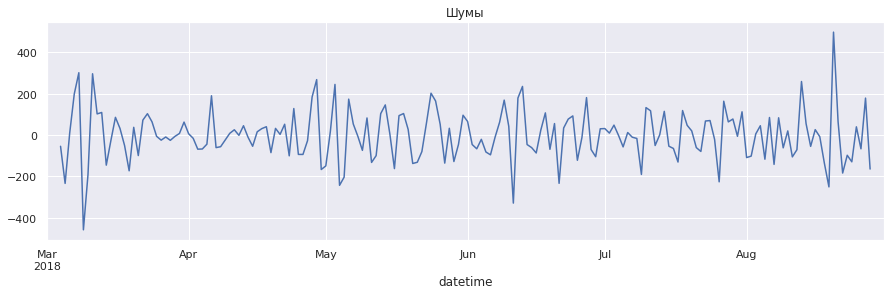

In [21]:
lineplot(decomposed_daily.resid, 'Шумы')

## Обучение

### Подготовка признаков

Создадим признаки для горизонта прогнозирования в один шаг

In [22]:
def get_features(df_learning):
    df_learning['day'] = df_learning.index.day
    df_learning['dayofweek'] = df_learning.index.dayofweek
    df_learning['hour'] = df_learning.index.hour
    
    for lag in (1,2,3,23,24,25,167,168,169):
        df_learning['lag_{}'.format(lag)] = df_learning['num_orders'].shift(lag)
    
    df_learning['rolling_mean'] = df_learning['num_orders'].shift().rolling(12).mean()
    df_learning.dropna(inplace=True)
    
    return df_learning

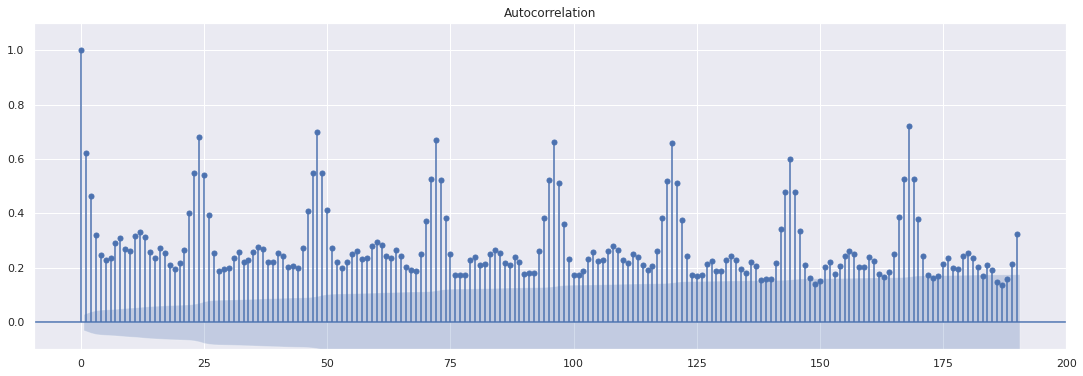

In [23]:

# Код ревьюера
from statsmodels.graphics import tsaplots

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 


In [24]:
df_learning = df.copy()
df_learning = get_features(df_learning)

In [25]:
df.shape

(4416, 1)

In [26]:
df_learning.shape

(4247, 14)

In [27]:
df_learning.head()

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_23,lag_24,lag_25,lag_167,lag_168,lag_169,rolling_mean
datetime,,,,,,,,,,,,,,
2018-03-08 01:00:00,78,8,3,1,143.0,94.0,127.0,24.0,121.0,100.0,71.0,85.0,124.0,78.333333
2018-03-08 02:00:00,65,8,3,2,78.0,143.0,94.0,66.0,24.0,121.0,66.0,71.0,85.0,80.250000
2018-03-08 03:00:00,68,8,3,3,65.0,78.0,143.0,73.0,66.0,24.0,43.0,66.0,71.0,82.083333
2018-03-08 04:00:00,60,8,3,4,68.0,65.0,78.0,10.0,73.0,66.0,6.0,43.0,66.0,83.500000
2018-03-08 05:00:00,6,8,3,5,60.0,68.0,65.0,19.0,10.0,73.0,12.0,6.0,43.0,84.666667


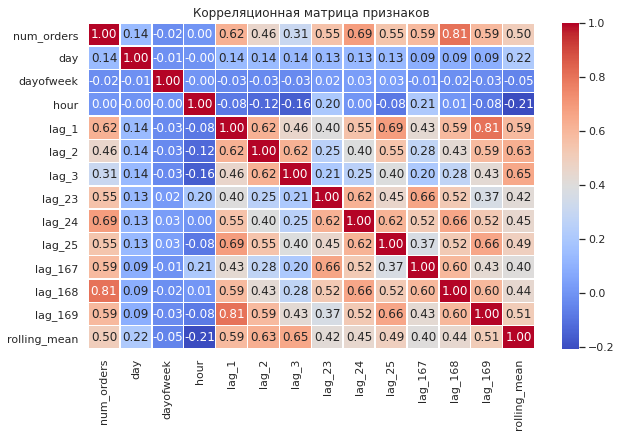

In [28]:
corr_matrix = df_learning.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Корреляционная матрица признаков')
plt.show()

Разделим данные на обучающую и тестовую выборки

In [29]:
features = df_learning.drop(['num_orders'], axis=1)
target = df_learning['num_orders']


In [30]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target,shuffle = False, test_size=0.1)


### Обучение моделей

In [31]:
train_models = []

In [32]:
tscv = TimeSeriesSplit(n_splits=2)

#### Линейная регрессия

In [33]:
param_grid = {
    'alpha': [0.1, 1, 10, 100], 
    'fit_intercept': [True, False],
    'normalize': [True, False]  
}

model = Ridge()

grid_search_rg = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search_rg.fit(features_train, target_train)

best_params = grid_search_rg.best_params_
print(f"Лучшие параметры: {best_params}")

Лучшие параметры: {'alpha': 0.1, 'fit_intercept': True, 'normalize': True}


In [34]:
predictions = grid_search_rg.predict(features_train)
rmse = mean_squared_error(target_train, predictions, squared=False)
rmse

22.374920279873102

In [35]:
train_models.append([model, rmse])

#### RandomForestRegressor

In [36]:
model = RandomForestRegressor(random_state=42)

In [37]:
parameters = {'n_estimators':range(50,100,10), 'max_depth':range(1,11,2)}


In [38]:
gsearch_rf = GridSearchCV(estimator=model, cv=tscv, param_grid=parameters)

In [39]:
gsearch_rf.fit(features_train, target_train)
gsearch_rf.best_params_

{'max_depth': 7, 'n_estimators': 90}

In [40]:
predictions = gsearch_rf.predict(features_train)
rmse = mean_squared_error(target_train, predictions, squared=False)
rmse

18.2816410736632

In [41]:
train_models.append([gsearch_rf, rmse])

#### CatBoost

In [42]:
param_grid = {
    'iterations': [500, 1000],  
    'learning_rate': [0.01, 0.05],  
    'depth': [5, 6]
}

model = CatBoostRegressor(verbose=False)
grid_search_cb = GridSearchCV(estimator=model, cv=tscv, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_cb.fit(features_train, target_train)
best_params = grid_search_cb.best_params_
print(f"Лучшие параметры: {best_params}")

Лучшие параметры: {'depth': 5, 'iterations': 1000, 'learning_rate': 0.01}


In [43]:
predictions = grid_search_cb.predict(features_train)
rmse = mean_squared_error(target_train, predictions, squared=False)
rmse

19.770458348918016

In [44]:
train_models.append([model, rmse])

### Результаты

In [45]:
result = pd.DataFrame(train_models, columns=['model', 'rmse_train'])

In [46]:
pd.options.display.max_colwidth = 0
display(result.sort_values(by='rmse_train'))

,model,rmse_train
1,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),\n estimator=RandomForestRegressor(random_state=42),\n param_grid={'max_depth': range(1, 11, 2),\n 'n_estimators': range(50, 100, 10)})",18.281641
2,<catboost.core.CatBoostRegressor object at 0x7fe71cce79d0>,19.770458
0,Ridge(),22.374920


Таким образом выберем лучшую модель по качеству обучения - RandomForestRegressor

## Тестирование

In [47]:
best_model = gsearch_rf.best_estimator_
predictions = best_model.predict(features_test)
rmse = mean_squared_error(target_test, predictions, squared=False)
rmse

43.442151745234526

Тетсирование модели на тетсовой выборке показало качество 43.4, что удовлетворяет условию ( меньше 48) 

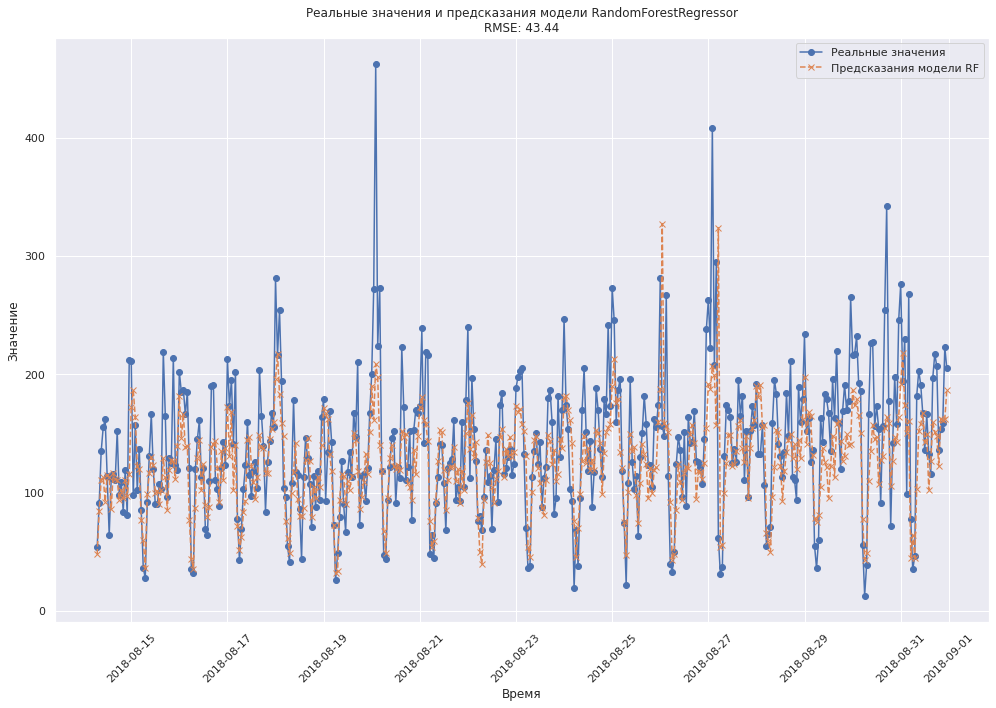

In [48]:
time_index = features_test.index

plt.figure(figsize=(14, 10))


plt.plot(time_index, target_test, label='Реальные значения', linestyle='-', marker='o')


plt.plot(time_index, predictions, label='Предсказания модели RF', linestyle='--', marker='x')


plt.title(f'Реальные значения и предсказания модели {type(best_model).__name__}\nRMSE: {rmse:.2f}')
plt.xlabel('Время')
plt.ylabel('Значение')


plt.legend()


plt.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout()  
plt.show()

Таким образом, выберем модель  - RandomForestRegressor. ЗаметимЮ что качетсов на тестовой выборке заметно упало ( в два раза) по сравнению с тренировочноый выборкой это связано с тем, что модель обучается на старых данных, и если в данных появляются новые паттерны ( меняется поведелние пользователей, сезонность, тренды, праздники, акции и прочее) то модель просто не успевает адоптировтася к ним.